# Essential portfolio math

This brief chapter will cover the type of statistics that we often see when looking at **portfolios**. Parts of the material, such as skewness and kurtosis, are also covered in **Chapter 13** of [Python for Finance, 2e](https://www.oreilly.com/library/view/python-for-finance/9781492024323/)

This material will have us thinking about **portfolio construction**. This type of portfolio construction is, typically, most helpful in a quantitative, or "quant", strategy. If you're picking 20 stocks to buy, you aren't going to run an optimizer. You'll probably just 1/n, or equally-weight, the positions. 

But, what if you have a lot of positions, probably chosen by some kind of quant or algorithmic strategy? You will be choosing and sizing the various trades (or, assets, more generally) to achieve a good trade-off between risk and expected return. What should you consider?

1. Diversification! Quant strategies might have 1000's of positions.
2. Position limits and risk limits: At the level of securities, asset classes, and overall portfolio. 
3. Larger bets on higher conviction trade. You can weight a position based on the strength of your signal.
4. Size bets in terms of risk.
5. Correlations matter: For a long position, correlation with other longs is bad, corr. with shorts is good. Powerful to go long/short within each industry, diversify across industries. Can use ETFs and futures to “hedge” out sector and market exposure.
6. Resize positions according to forward-looking risk and conviction.

We won't start with full-on quantitative-based strategies though. Let's look at a few, basic return series. 
   
We'll start by bringing in some **monthly hedge fund return data**. We'll calculate some portfolio returns, using assumed weights. We'll then move on to portfolio-level **variance and standard deviation**. We'll see how to **annualize returns and volatility**. We'll look at other risk measures, like **skewness** and **kurtosis**. We'll see **Sharpe** and **Sortino** ratios. Finally, we'll make a graph showing the **drawdown**, or worse loss, of our portfolio.

These ideas will get us thinking about portfolios, trading strategies, risk management, and portfolio optimization. We'll go into more detail in later chapters.

The formulas are **must knows** for finance folks! For example, you need these on CFA Level 1.


In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import janitor
from janitor import clean_names

# This brings in all of matplotlib
import matplotlib as mpl 

# This lets us refer to the pyplot part of matplot lib more easily. Just use plt!
import matplotlib.pyplot as plt

# Include this to have plots show up in your Jupyter notebook.
%matplotlib inline 

hf = pd.read_excel('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/hf_rets.xlsx',
                  index_col=0, parse_dates=True)  

hf = hf.clean_names()

hf.describe()

,rf,mkt_rf,smb,hml,umd,ln_sh_eq_hedge_fund_usd,eq_mkt_ntr_hedge_fund_usd,ded_sh_bs_hedge_fund_usd,global_mac_hedge_fund_usd,mngd_fut_hedge_fund_usd,emg_mkts_hedge_fund_usd,evnt_drvn_hedge_fund_usd,_cnvrt_arb_hedge_fund_usd,fx_inc_arb_hedge_fund_usd,djcs_hedge_fund_usd
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,0.002536,0.005089,0.002121,0.002133,0.004886,0.007535,0.004410,-0.002217,0.009594,0.005108,0.006656,0.007360,0.006129,0.004366,0.007011
std,0.001742,0.047007,0.035581,0.033738,0.054827,0.028745,0.029770,0.049144,0.028000,0.033738,0.042929,0.018291,0.019981,0.016485,0.021820
min,0.000000,-0.185500,-0.166200,-0.128700,-0.347500,-0.114806,-0.404590,-0.112825,-0.115652,-0.093702,-0.230716,-0.118201,-0.126007,-0.140442,-0.075948
25%,0.000900,-0.023225,-0.019750,-0.015275,-0.011225,-0.008805,0.001250,-0.033677,-0.001949,-0.018947,-0.012924,0.000110,-0.000482,0.001716,-0.002376
50%,0.003000,0.011550,-0.001450,0.002150,0.006300,0.007663,0.006715,-0.007478,0.010404,0.003235,0.012111,0.009848,0.009817,0.007131,0.007447
75%,0.004100,0.035600,0.023025,0.017750,0.030425,0.023168,0.012581,0.029215,0.021420,0.028790,0.028144,0.018590,0.014712,0.011529,0.018074
max,0.005600,0.115300,0.220600,0.138800,0.184000,0.129913,0.036573,0.226661,0.105808,0.099063,0.164018,0.042168,0.058055,0.043331,0.085117


There's a lot there, so let's just keep four different columns. These columns represent the average monthly return for that hedge fund type. I'm keeping long/short equity, equity market neutral, global macro, managed futures.

Long/short equity funds do what the name says -- they go long and short stocks, generally keeping their market beta less than one. But not that different from traditional mutual funds.

Equity market neutral might aim for a beta of zero, but usually have more exposure than that. They are trying to get rid of their risk exposures and just earn alpha from security mispricings. Easier said than done.

Global macro funds make trades based on broad market trends, currencies, and other markets affected by macro events, like inflation or economic growth. They don't buy or sell individual stocks and often use futures contracts to get their exposures. 

Finally, managed futures are similar, but tend to follow trend-following strategies. They buy stuff that's been going up and sell stuff that's been going down. Some investors use them as diversifiers in their portfolios.

You'll see more on these ideas in the factor model notes.

In [2]:
rets = hf.iloc[:,[5, 6, 8, 9]]
rets

,ln_sh_eq_hedge_fund_usd,eq_mkt_ntr_hedge_fund_usd,global_mac_hedge_fund_usd,mngd_fut_hedge_fund_usd
date,,,,
1994-01-31,0.011733,-0.005467,0.001433,0.001933
1994-02-28,-0.025011,0.002106,-0.056811,0.011667
1994-03-31,-0.039114,-0.002514,-0.042854,0.025923
1994-04-29,-0.015720,0.002397,-0.016033,0.008437
1994-05-31,0.005550,-0.001229,0.037839,0.007497
...,...,...,...,...
2012-02-29,0.026418,0.013335,0.007852,0.012039
2012-03-30,0.004998,-0.001553,-0.004271,-0.029648
2012-04-30,-0.004680,-0.004139,-0.002522,0.004299


I used `.iloc` to keep the columns I wanted. Easier to use a column number reference than type out these long names.

## Geometric vs. arithmetic averages

In order to think about portfolio returns, we also need to understand the relationship between an arithmetic average and the geometric average, and when to use one vs. another.

This article, [by the financial planner Michael Kitches](https://www.kitces.com/blog/volatility-drag-variance-drain-mean-arithmetic-vs-geometric-average-investment-returns/), is a great explanation of why the difference matters and how **volatility drag** affects your total return. From his summary:

> In the investment world, it’s common to discuss average rates of return, both in a backward-looking fashion (e.g., to report investment results), and in a more forward-looking manner (e.g., to project the average growth rate of investments for funding future goals in retirement planning software). However, the reality is that because returns are linked to each other – the return in one year increases or decreases the available wealth to compound in the subsequent year – it’s not sufficient to simply determine an “average” return by adding up all the historical returns and dividing by how many there are.

> Instead of this traditional “arithmetic mean” approach to calculating an average, in the case of investment returns, the proper way to calculate average returns is with a geometric mean, that takes into account the compounding effects of a series of volatile returns over time. Which is important, because in practice the geometric average return is never as high as its arithmetic mean counterpart, due to the fact that volatility always produces some level of “volatility drag”, which can be estimated by subtracting ½ of the investment’s variance (standard deviation squared) from its arithmetic return.

> Fortunately, the reality is that most investment returns, as commonly discussed by financial advisors, are already reported as geometric returns, typically stated as either a Compound Average Growth Rate (CAGR), an annualized return, or some similar label. Which means, intended or not, most financial advisors already project future wealth values in a retirement plan using the (proper) geometric return assumption.

> However, the variance drain on a sequence of volatile returns still matters when financial advisors use Monte Carlo analysis, which by design actually projects sequences of random volatile returns (based on the probability that they will occur) to determine the outcome of particular retirement strategies. Because the fact that volatility drag is already part of a Monte Carlo analysis means that the return assumption plugged into a Monte Carlo projection should actually be the (higher) arithmetic return, and not the investment’s long-term compound average growth rate. Otherwise, the impact of volatility drag is effectively counted twice, which can understate long-term returns and overstate the actual risk of the prospective retirement plan!

We can put that reasoning into a simple, but important formula.

\begin{align}
\text{Compound Return}_i = E[R_p] - \frac{1}{2}\sigma^2_p
\end{align}

where $E[R_i]$ is the arithmetic mean of the portfolio (i.e. the expected return) and $\sigma^2_p$ is the variance of the portfolio. Note that this math works for single assets, too. It isn't portfolio specific.

```{hint}
This is yet another formula that appears on the CFA and CFP exams.
```

Believe it or not, just figuring out how to calculate returns in order to create projections (e.g. for a client portfolio) is a controversial, non-trivial task. Two of the authors of your FIN 4120 investments textbook suggest that you should forecast the value of a portfolio using an average [between the arithmetic and geometric](https://www.tandfonline.com/doi/abs/10.2469/faj.v59.n6.2574?src=recsys).

I like this discussion, too, by Kris Abdelmessih, an options trader who also writes the [Moontower Substack](https://moontower.substack.com/p/well-what-did-you-expect):

> What you expect to happen in the colloquial sense of the term is the geometric mean. The arithmetic average is a measure of centrality when you sum the results and divide by the number of results. (In our examples you are summing results weighted by their probabilities, but you are still summing). The geometric mean corresponds to the median result of a compounding process. Compounding means “multiplying not summing”. The median is the measure that maps to our colloquial use of “expected” because it’s the 50/50 point of the distribution. That’s the number you plan life around.

> The theoretical arithmetic mean result of playing the lotto might be losing 50% of your $2 Powerball ticket (which is another way of saying you are paying 2x what the ticket is mathematically worth). The median result is you lit your cash on fire. You plan your life around the median, especially when it’s far away from the mean. We’ll come back to that.


Here's [a link](https://www.dropbox.com/s/ph4xmjt5wsobeuv/Well%20What%20Did%20You%20%22Expect%22%3F%20-%20Party%20at%20the%20Moontower.pdf?dl=0) to a PDF of that Substack post. If you're interested in trading, options, math puzzles, etc., check out his work. I don't agree with every conclusion, but I like the way he breaks things down into the step-by-step logic of underlying math.

## Portfolio-level returns

Let's define an array of weights. We'll put 25% of our money into each style category. This isn't actually an investable strategy, since you can't invest in the average hedge fund!

In [3]:
wgts = np.array([0.25, 0.25, 0.25, 0.25])

We can find the monthly means for each strategy. I'll multiply each by 100, name the column, and then turn the series into a DataFrame. You need the table to be a DataFrame in order to style it. I then use a **dictionary** to change the row names. Remember, a Python dictionary matches one item to another. I finally style the number format.

In [4]:
monthly_rets_avg = rets.mean().mul(100)

monthly_rets_avg = monthly_rets_avg.rename('Monthly Return')

monthly_rets_avg = monthly_rets_avg.to_frame()

monthly_rets_avg = monthly_rets_avg.rename({'ln_sh_eq_hedge_fund_usd':'L/S Equity','eq_mkt_ntr_hedge_fund_usd':'Equity Market Neutral','global_mac_hedge_fund_usd':'Global Macro','mngd_fut_hedge_fund_usd':'Managed Futures'}, axis='rows')

monthly_rets_avg = monthly_rets_avg.style.format('{:.3f}%').set_caption('Hedge Fund Style Returns') 

monthly_rets_avg

,Monthly Return
L/S Equity,0.754%
Equity Market Neutral,0.441%
Global Macro,0.959%
Managed Futures,0.511%


The **method chaining** to writing the code step-by-step to make the table works too. I find this easier to read. Note that I'm **not** saving the table as a DataFrame anywhere, though I could. I do one action and then the output gets passed on to the next action.

In [5]:
(
    rets.mean()
    .mul(100)
    .rename('Monthly Return')
    .to_frame()
    .rename({'ln_sh_eq_hedge_fund_usd':'L/S Equity','eq_mkt_ntr_hedge_fund_usd':'Equity Market Neutral','global_mac_hedge_fund_usd':'Global Macro','mngd_fut_hedge_fund_usd':'Managed Futures'}, axis='rows')
    .style
        .format('{:.3f}%')
        .set_caption('Hedge Fund Style Returns')   
)

,Monthly Return
L/S Equity,0.754%
Equity Market Neutral,0.441%
Global Macro,0.959%
Managed Futures,0.511%


We can also see what our equally-weighted portfolio would have done per month over that time period. I'll remake the monthly average returns, since you can't use it for math now that it's been styled.

In [6]:
monthly_rets_avg = rets.mean()
hf_port_ret = np.sum(monthly_rets_avg * wgts)
hf_port_ret

0.0066618444208333735

Let's weight each month's returns by our weights so that we can then calculate monthly portfolio returns.

In [7]:
weighted_returns = (wgts * rets)

I'm calculating monthly returns by summing up across each row. That's the `axis=1` argument. I'm then naming this series *port_ret*.

In [8]:
port_ret = weighted_returns.sum(axis=1).rename('port_ret')


I'll join my portfolio returns to the monthly fund returns. There should be the same number of portfolio returns as individual hedge fund returns.

In [9]:
rets_with_port = rets.join(port_ret)

And, I can calculate cumulative returns and then graph them. As we've seen using a function like `.cumprod()` like this is an example of **broadcasting** and **vectorization**. I am adding 1 to every monthly return and then applying the `.cumprod()` function to each observation. Take a look at the result to see what happened. 

I'll also rename the columns a slightly different way. Notice that I'm using `inplace=True` and have the column names inside of a **dictionary**. 

In [10]:
monthly_cum_rets = (1+rets_with_port).cumprod()
monthly_cum_rets.rename(columns={'ln_sh_eq_hedge_fund_usd':'L/S Equity', 'eq_mkt_ntr_hedge_fund_usd':'Equity Market Neutral', 'global_mac_hedge_fund_usd':'Global Macro', 'mngd_fut_hedge_fund_usd':'Managed Futures', 'port_ret':'EW Port Ret' }, inplace=True)

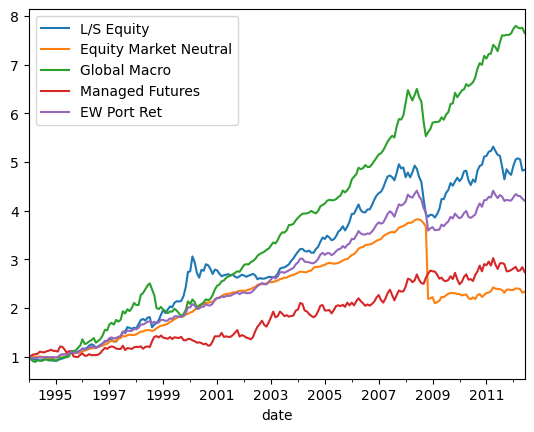

In [11]:
monthly_cum_rets.plot();

Yikes! Check out the orange line - equity market neutral funds aren't necessarily very market neutral!

## Risk measures at the portfolio-level

As you know from your investments class, the variance of a portfolio is **not** the average variance of the assets in the portfolio. We need to take into account the effects of **diversification**. For example, here's the formula for the variance of a portfolio with two assets. We need weights, variances, and the covariance between the two.

\begin{align}
\sigma^2_p = w^2_1 \sigma^2_1 + w^2_2 \sigma^2_2 + 2 w_1 w_2 \sigma^2_{1,2}
\end{align}

That last sigma, $\sigma^2_{1,2}$, is the **covariance** between the two assets. 

This formula generalizes for **any number of assets**. 

\begin{align}
\sigma^2_p = w^T \Sigma w
\end{align}

where $w$ is a **vector** containing all of our portfolio weights and sigma is the variance-covariance matrix for our assets. The "T" means the matrix operation **transpose**. This is necessary for the matrix multiplication. 

Let's use Python to find the variance-covariance matrix. There are variances along with diagonal of the matrix and covariance terms **between assets** in the off-diagonals. Note that upper-right and lower-left of the matrix are identical. This is because the covariance between Asset 1 and Asset 2 is the same as the covariance between Asset 2 and Asset 1. 

In [12]:
cov_matrix = rets.cov()
cov_matrix

,ln_sh_eq_hedge_fund_usd,eq_mkt_ntr_hedge_fund_usd,global_mac_hedge_fund_usd,mngd_fut_hedge_fund_usd
ln_sh_eq_hedge_fund_usd,0.000826,0.000192,0.000362,0.000066
eq_mkt_ntr_hedge_fund_usd,0.000192,0.000886,0.000069,0.000005
global_mac_hedge_fund_usd,0.000362,0.000069,0.000784,0.000283
mngd_fut_hedge_fund_usd,0.000066,0.000005,0.000283,0.001138


We can also find the correlation matrix. Correlation ($\rho$) is the **covariance between two assets divided by the standard deviation of each asset multiplied together**: $\rho_{1,2} = \frac{\sigma_{1,2}}{\sigma_1 \sigma_2}$

In [13]:
corr_matrix = rets.corr()
corr_matrix

,ln_sh_eq_hedge_fund_usd,eq_mkt_ntr_hedge_fund_usd,global_mac_hedge_fund_usd,mngd_fut_hedge_fund_usd
ln_sh_eq_hedge_fund_usd,1.000000,0.224745,0.450291,0.068435
eq_mkt_ntr_hedge_fund_usd,0.224745,1.000000,0.083255,0.005156
global_mac_hedge_fund_usd,0.450291,0.083255,1.000000,0.299970
mngd_fut_hedge_fund_usd,0.068435,0.005156,0.299970,1.000000


The correlation among these general strategies is pretty low! That's good for portfolio formation. In fact, strategies like managed futures are often considered a diversifier in a traditional equity and bond portfolio. 

Let's use our general formula, our weights, and the cov matrix to find **portfolio variance**. We'll use `np.dot()` from `numpy` to do the dot product. This is like **mmult** in Excel. The `.T` transposes, or flips, the vector of returns so that we can multiply. 

In [14]:
port_variance = np.dot(wgts.T, np.dot(cov_matrix, wgts))
port_variance

0.0003495578603062863

Here's a [refresher on matrix multiplication](https://www.mathsisfun.com/algebra/matrix-multiplying.html) in case you need it.

Portfolio standard deviation is, of course, just the square root of variance. We can use `np.sqrt()`. 

In [15]:
port_stddev = np.sqrt(np.dot(wgts.T, np.dot(cov_matrix, wgts)))
print(str(np.round(port_stddev, 3) * 100) + '%')

1.9%


## Skewness and kurtosis

We'll look more at the distribution of asset returns when we get to a more formal treatment of risk management. But, for now, we need to know that asset returns, like stocks, and even portfolio returns, like those of a hedge fund, are not typically normally distributed. They "lean", or have **skewness**. That skewness can be either positive or negative, depending on the strategy. They also have **kurtosis**, or "fat tails". This means that there are more extreme returns than you would expect if they followed a normal distribution.

It is easy to find both in Python.

In [16]:
rets_with_port.skew()

ln_sh_eq_hedge_fund_usd      -0.012623
eq_mkt_ntr_hedge_fund_usd   -11.866451
global_mac_hedge_fund_usd     0.016477
mngd_fut_hedge_fund_usd       0.026489
port_ret                     -0.386969
dtype: float64

It's easier to see what skewness and kurtosis mean with pictures.

```{figure} ../images/08-skew.png
---
name: 08-skew.png
align: center
---
Some strategies, like selling options, have negative skewness. You make a small profit much of the time -- until you don't. Other investments have positive skewness. You'll lose money much of the time, but occasionally get a large payoff. Some volatility-protection strategies look like this. Source: DataCamp.
```

In [17]:
rets_with_port.kurt()

ln_sh_eq_hedge_fund_usd        3.186683
eq_mkt_ntr_hedge_fund_usd    162.760371
global_mac_hedge_fund_usd      3.888268
mngd_fut_hedge_fund_usd       -0.017587
port_ret                       3.306429
dtype: float64

```{figure} ../images/08-kurt.png
---
name: 08-kurt.png
align: center
---
Many investment strategies have more "rare events" or larger gains and losses than you would expect if returns followed the normal distribution. Source: DataCamp.
```

## Annualizing and adjusting for risk

There are many ways to report returns. We've seen discrete vs. log returns. There are returns for specific period, like a day or a month. We can then take that specific period return and **annualize** it. This takes a return over a shorter time frame and asks what are return would be if we earned that return over a year.

We can also annualize a multi-year return and ask what annual return would have gotten us the same multi-year return.

Both of these ideas are really the same thing mathematically and take into account **compounding**. They let us compare returns that are different time periods. Fund managers that fall under the SEC '40 Act are required to report calculations like this.

There are also many ways to **adjust for risk**. Why do we need to adjust for risk? Simply put, you can go to a casino and put all of your money on black, get lucky, and double your "investment". But I don't want you managing my money! Your risk-adjusted return is zero. 

The same thing is true for trading securities, like stocks, bonds, options, and crypto. You can buy a penny stock, or a Dog coin, or a deep out-of-the-money call option and make a lot of money. And that money is real - you can spend it! But, we need ways to disentangle return, risk, and luck if we're going to assign skill to someone's good forture. 

Let's combine these two ideas, getting our return and risk measures in the same time units and taking risk into account, to calculate to basic risk-adjustment measures: the **Sharpe Ratio** and the **Sortino Ratio**.

We'll look at **factor models** in another chapter. This is a more comprehensive way to adjust our returns for the risks that we're taking in order to see if we have skill. 

Let's use the monthly portfolio returns that I created above to find our measures of risk/return trade-off. I will first annualize my monthly return. I will then annualize my monthly standard deviation, or volatility as we say in finance. I am "cheating" a bit on my volatility annualization. These are discrete returns. Multiplying by the square root of the number of your time periods in a year (12, because we have montly returns) really only works if you have log returns.

See your Principles of Finance notes for more on these calculations.

In [18]:
risk_free = 0.02
 
port_ret = rets_with_port.port_ret
port_ret.describe()

count    222.000000
mean       0.006662
std        0.018696
min       -0.092835
25%       -0.004634
50%        0.006880
75%        0.017815
max        0.065128
Name: port_ret, dtype: float64

In [19]:
annualized_return=((1 + port_ret.mean())**(12))-1
annualized_vol = port_ret.std()*np.sqrt(12)

Note that `**` denotes exponent, while `*` is multiplication in Python. 

We can then calculate the **Sharpe Ratio**, which is the ratio of returns above the risk-free rate to the volatility (i.e. the risk) in the portfolio.

In [20]:
sharpe_ratio = (annualized_return - risk_free) / annualized_vol
sharpe_ratio

0.9717568897720553

We have a Sharpe near 1. That's pretty high! Hedge fund strategies often take risks that are not well-defined by standard deviation. For example, if a strategy has a lot of negative skewness, then we would expect to occasionally have large losses. Volatility doesn't capture that type of risk.

Returns that are "too smooth" can also create artificially low Sharpe Ratios. For example, if a strategy holds illiquid securities that are not marked-to-market (or priced) consistently, then the reported returns won't affect the actual volatility of the positions if they were priced, say, daily. For example, many venture capital and private equity strategies only mark, or change the prices of their investments, quarterly. A mutual fund is going to see their positions market daily. ETFs trade throughout the day. Private equity strategies look less volatile than they really are and, so, have higher Sharpe ratios than they do in reality. 

We can also calculate the **Sortino Ratio**. This looks very similar to the Sharpe Ratio, expect that we only calculate the standard deviation using returns below some target, or threshold. So, we are interesting in volatility during bad times, not just overall volatility. We often use a target of 0 to look at negative returns, but you can choose something else if that's appropriate.

Note that I am masking with `.loc` to get just the negative returns from the *port_ret* Series.

In [21]:
target_return = 0

negative_returns = port_ret.loc[port_ret < target_return]

down_stdev = negative_returns.std()*np.sqrt(12)

sortino_ratio = (annualized_return - risk_free)/down_stdev

sortino_ratio

1.4514485366477672

## Drawdowns

We might also be interested in draw-downs, or what the bad times look like, how long they last, and how long it takes to get our money back.

We will calculate the cumulative portfolio return, the previous maximum cumulative return (often called a **high water mark**), and the percentage below the high water mark at any point. 

I print my index, just to show you that *date* is the index of the *port_drawdown* DataFrame. So, my x-axis in my plots can just be `port_drawdown.index`. 

I am using `matplotlib` and `plt.plot` to make two stacked line charts. I find this to be the easiest way, even if it is more verbose. You can really see what you're doing in each step.

In [22]:
port_ret_cum = (1+port_ret).cumprod()
previous_peaks = port_ret_cum.cummax()
drawdowns = (port_ret_cum - previous_peaks)/previous_peaks

port_drawdown = pd.DataFrame({'Cumulative Return': port_ret_cum, 'Previous Peak': previous_peaks, 'Drawdown': drawdowns})

print(port_drawdown.index)

DatetimeIndex(['1994-01-31', '1994-02-28', '1994-03-31', '1994-04-29',
               '1994-05-31', '1994-06-30', '1994-07-29', '1994-08-31',
               '1994-09-30', '1994-10-31',
               ...
               '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-30',
               '2012-01-31', '2012-02-29', '2012-03-30', '2012-04-30',
               '2012-05-31', '2012-06-29'],
              dtype='datetime64[ns]', name='date', length=222, freq=None)


Let's make the graph. You'll see that the Great Financial Crisis was the high water mark, at least in this data.

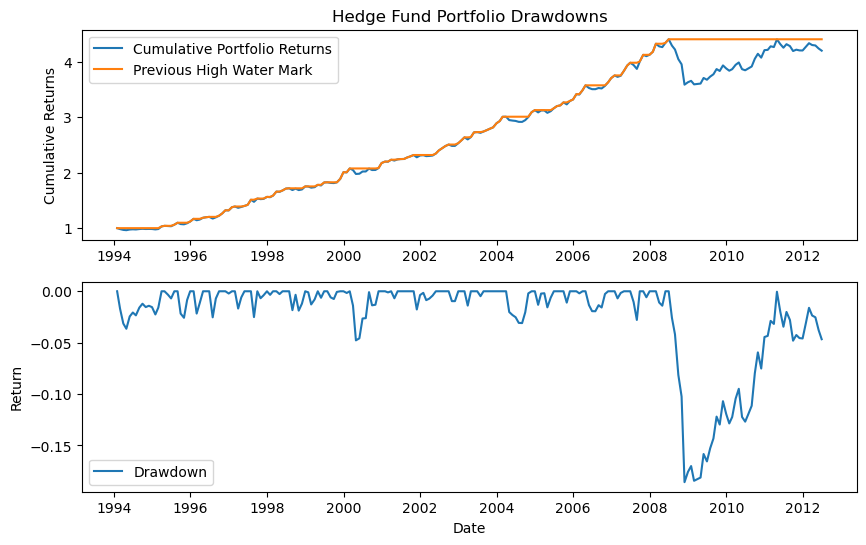

In [23]:
plt.figure(figsize=(10, 6))

plt.subplot(211)
plt.plot(port_drawdown.index, port_drawdown['Cumulative Return'], lw=1.5, label='Cumulative Portfolio Returns')
plt.plot(port_drawdown.index, port_drawdown['Previous Peak'], lw=1.5, label='Previous High Water Mark')
plt.legend(loc=0)
plt.ylabel('Cumulative Returns')
plt.title('Hedge Fund Portfolio Drawdowns')

plt.subplot(212)
plt.plot(port_drawdown.index, port_drawdown['Drawdown'], lw=1.5, label='Drawdown')
plt.legend(loc=0)
plt.xlabel('Date')
plt.ylabel('Return');